In [1]:
import json
import torch
import numpy as np
import os
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader 
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
from torch_geometric.utils import to_dense_batch
import torch.optim as optim
import json

sys.path.append(os.path.abspath(".."))

#### 1. Make Data Loaders

- Please indicate the directory where the json graphical dataset is located

- Additionally you can change the following parameters:

    - mode: This lets you choose which features to include in the loaded data. The options are:
        - all: includes all nodes and edges
        - ego_veh: includes all ego and vehicle nodes and edges
        - ego: includes only ego nodes and edges
        - ego_env: includes all ego and environment nodes and edges
        - all_no_edges: includes all node features but no edges
        - ego_veh_no_edges: includes all ego and vehicle node features but no edges
        - ego_no_edges: includes only ego node features with no edges
        - ego_env_no_edges: includes all ego and environment node features but no edges

    - normalize: True/False. If true, this applies a normalization transform + nan to num

    - norm_methos: zscore or l2

In [2]:
from functions.data_loaders import get_graph_dataset

l2d_train_set = get_graph_dataset("../data/processed_graphical/l2d/", 
                                  mode="ego", normalize=True, norm_method="zscore")
l2d_train_loader = DataLoader(l2d_train_set, batch_size=64, shuffle=True)

print(f"Total graphs: {len(l2d_train_set)}")  
for data in l2d_train_loader:
    print(data) 
    break

print('===========')

nup_train_set = get_graph_dataset("../data/processed_graphical/nuplan/", 
                                  mode="ego", normalize=True, norm_method="zscore")
nup_train_loader = DataLoader(l2d_train_set, batch_size=64, shuffle=True)

print(f"Total graphs: {len(nup_train_set)}")  
for data in l2d_train_loader:
    print(data) 
    break

Total graphs: 9593
HeteroDataBatch(
  ego={
    x=[492, 6],
    batch=[492],
    ptr=[65],
  },
  window_meta={ episode_path=[64] },
  (ego, to, ego)={ edge_index=[2, 428] }
)
Total graphs: 88370
HeteroDataBatch(
  ego={
    x=[517, 6],
    batch=[517],
    ptr=[65],
  },
  window_meta={ episode_path=[64] },
  (ego, to, ego)={ edge_index=[2, 453] }
)


### 🚧 Under Construction 🚧

In [3]:
from functions.models import GraphEmbedder, ProjectionHead, kl_divergence_between_gaussians

batch_l2d = next(iter(l2d_train_loader))
batch_nup = next(iter(nup_train_loader))

node_dims_l2d = {
    node_type: batch_l2d[node_type].x.size(1)
    for node_type in batch_l2d.node_types
    if hasattr(batch_l2d[node_type], 'x')
}

node_dims_nup = {
    node_type: batch_nup[node_type].x.size(1)
    for node_type in batch_nup.node_types
    if hasattr(batch_nup[node_type], 'x')
}

print("L2D node dims:", node_dims_l2d)
print("NUP node dims:", node_dims_nup)

l2d_encoder = GraphEmbedder(node_dims_l2d, hidden_dims=[64,128,32])
nup_encoder = GraphEmbedder(node_dims_nup, hidden_dims=[64,128,32])
projector = ProjectionHead(in_dim=32, proj_dim=16)

L2D node dims: {'ego': 6}
NUP node dims: {'ego': 6}


In [4]:
z_l2d = projector(l2d_encoder(batch_l2d))  # [B, 128]
z_nup = projector(nup_encoder(batch_nup))  # [B, 128]
loss = kl_divergence_between_gaussians(z_l2d, z_nup)
loss

tensor(3428.4546, grad_fn=<MulBackward0>)

In [ ]:
import torch
from tqdm import tqdm

# Send models to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
l2d_encoder = l2d_encoder.to(device)
nup_encoder = nup_encoder.to(device)
projector = projector.to(device)

# Optimizer for all params
optimizer = torch.optim.Adam(
    list(l2d_encoder.parameters()) + 
    list(nup_encoder.parameters()) + 
    list(projector.parameters()), 
    lr=1e-4
)

# Number of epochs
num_epochs = 40

for epoch in range(num_epochs):
    l2d_encoder.train()
    nup_encoder.train()
    projector.train()

    total_loss = 0.0

    pbar = tqdm(zip(l2d_train_loader, nup_train_loader), 
                total=min(len(l2d_train_loader), len(nup_train_loader)), 
                desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_l2d, batch_nup in pbar:
        batch_l2d = batch_l2d.to(device)
        batch_nup = batch_nup.to(device)

        z_l2d = projector(l2d_encoder(batch_l2d))  # [B, D]
        z_nup = projector(nup_encoder(batch_nup))  # [B, D]

        z_l2d = F.normalize(z_l2d, dim=-1)
        z_nup = F.normalize(z_nup, dim=-1)
        loss = kl_divergence_between_gaussians(z_l2d, z_nup) + kl_divergence_between_gaussians(z_nup, z_l2d)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(pbar)
    print(f"Epoch {epoch+1} complete. Average KL Loss: {avg_loss:.4f}")

In [9]:
import umap.umap_ as umap
import plotly.express as px
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

l2d_encoder.eval()
nup_encoder.eval()
projector.eval()

all_embeddings = []
all_sources = []
all_paths = []

with torch.no_grad():
    for batch in tqdm(l2d_train_loader, desc="Collecting L2D embeddings"):
        batch = batch.to(device)
        z = projector(l2d_encoder(batch))  # [B, D]
        all_embeddings.append(z.cpu())
        all_sources.extend(['l2d'] * z.size(0))
        all_paths.extend(batch['window_meta']['episode_path'])

    for batch in tqdm(nup_train_loader, desc="Collecting NUP embeddings"):
        batch = batch.to(device)
        z = projector(nup_encoder(batch))  # [B, D]
        all_embeddings.append(z.cpu())
        all_sources.extend(['nup'] * z.size(0))
        all_paths.extend(batch['window_meta']['episode_path'])

# Concatenate
all_embeddings = torch.cat(all_embeddings, dim=0)  # [N, D]

# UMAP reduction
reducer = umap.UMAP(n_components=2, random_state=42)
emb_2d = reducer.fit_transform(all_embeddings.numpy())  # [N, 2]

# Convert to DataFrame for Plotly
df = pd.DataFrame({
    'UMAP1': emb_2d[:, 0],
    'UMAP2': emb_2d[:, 1],
    'Source': all_sources,
    'EpisodePath': all_paths
})

# Interactive plot
fig = px.scatter(
    df,
    x='UMAP1',
    y='UMAP2',
    color='Source',
    hover_data=['EpisodePath'],
    opacity=0.6,
    title="Graph Embedding Space (UMAP Projection)",
    color_discrete_map={'l2d': 'royalblue', 'nup': 'darkorange'}
)
fig.update_traces(marker=dict(line=dict(width=0.2, color='black')))
fig.update_layout(
    xaxis_title="UMAP-1",
    yaxis_title="UMAP-2",
    legend_title="Source",
    template='simple_white'
)
fig.show()

/Users/mariantemprana/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [37]:
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

l2d_encoder.eval()
nup_encoder.eval()
projector.eval()

all_embeddings = []
all_sources = []
all_paths = []

with torch.no_grad():
    for batch in tqdm(l2d_train_loader, desc="Collecting L2D embeddings"):
        batch = batch.to(device)
        z = projector(l2d_encoder(batch))  # [B, D]
        all_embeddings.append(z.cpu())
        all_sources.extend(['l2d'] * z.size(0))
        all_paths.extend(batch['window_meta']['episode_path'])

    for batch in tqdm(nup_train_loader, desc="Collecting NUP embeddings"):
        batch = batch.to(device)
        z = projector(nup_encoder(batch))  # [B, D]
        all_embeddings.append(z.cpu())
        all_sources.extend(['nup'] * z.size(0))
        all_paths.extend(batch['window_meta']['episode_path'])

# Concatenate
all_embeddings = torch.cat(all_embeddings, dim=0)  # [N, D]

# PCA reduction
pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(all_embeddings.numpy())  # [N, 2]

# Convert to DataFrame for Plotly
df = pd.DataFrame({
    'PCA1': emb_2d[:, 0],
    'PCA2': emb_2d[:, 1],
    'Source': all_sources,
    'EpisodePath': all_paths
})

# Interactive plot
fig = px.scatter(
    df,
    x='PCA1',
    y='PCA2',
    color='Source',
    hover_data=['EpisodePath'],
    opacity=0.6,
    title="Graph Embedding Space (PCA Projection)",
    color_discrete_map={'l2d': 'royalblue', 'nup': 'darkorange'}
)
fig.update_traces(marker=dict(line=dict(width=0.2, color='black')))
fig.update_layout(
    xaxis_title="PCA-1",
    yaxis_title="PCA-2",
    legend_title="Source",
    template='simple_white'
)
fig.show()

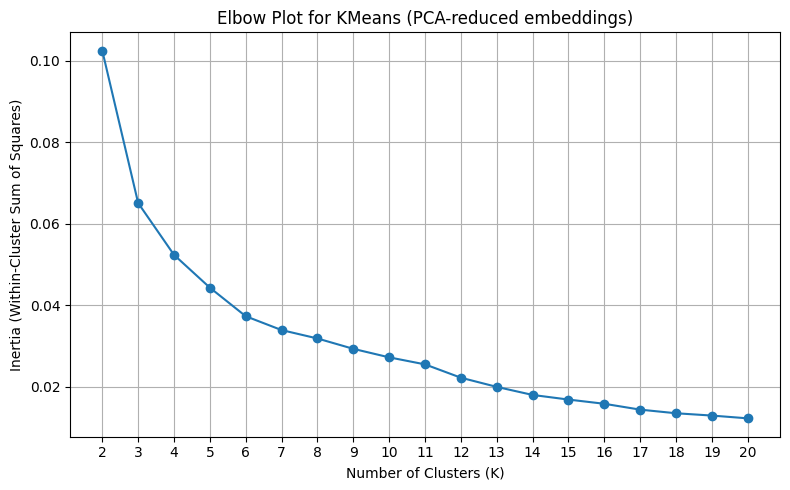

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Sweep K values ---
k_values = range(2, 21)
inertias = []

# PCA reduction to 10D
#pca = PCA(n_components=10, random_state=42)
embeddings_10d = all_embeddings

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(embeddings_10d)
    inertias.append(kmeans.inertia_)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Plot for KMeans (PCA-reduced embeddings)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

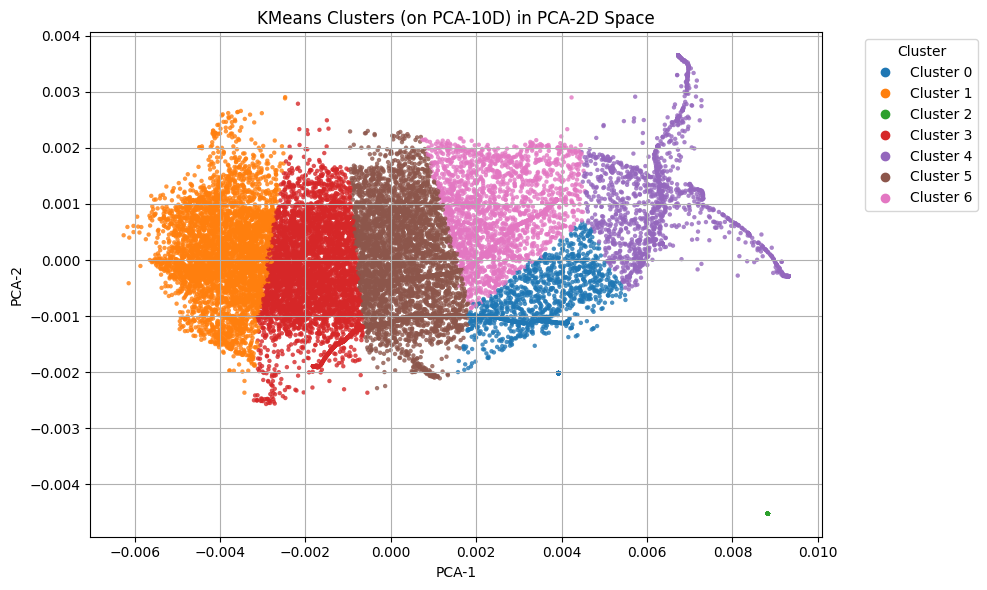

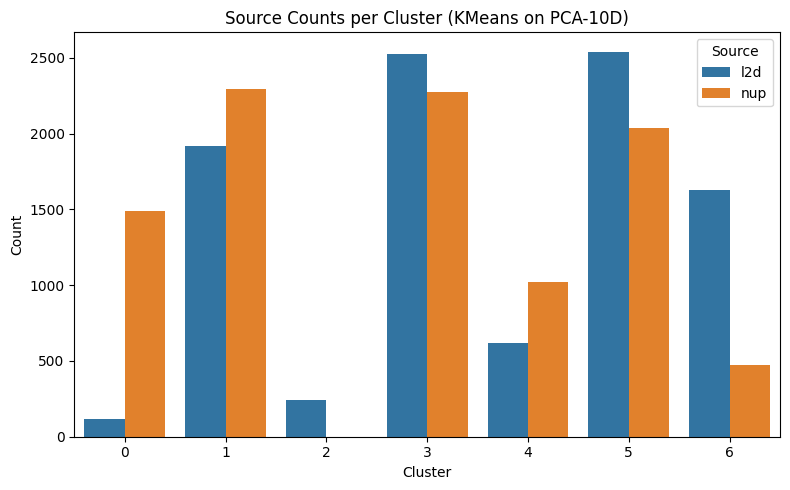

In [39]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_clusters = 7

# --- Reduce to 10D using PCA for clustering ---
pca_10d = PCA(n_components=10, random_state=42)
embeddings_10d = pca_10d.fit_transform(all_embeddings)

# --- KMeans Clustering ---
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(embeddings_10d)

# --- PCA Projection (2D) for Visualization ---
pca_2d = PCA(n_components=2, random_state=42)
proj_2d = pca_2d.fit_transform(all_embeddings)

# --- PCA Plot ---
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_clusters)
colors = [palette[label] for label in cluster_labels]

plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c=colors, s=10, alpha=0.8, linewidth=0)
plt.title("KMeans Clusters (on PCA-10D) in PCA-2D Space")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)

handles = [plt.Line2D([], [], marker='o', color=c, linestyle='', label=f'Cluster {i}')
           for i, c in enumerate(palette)]
plt.legend(handles=handles, title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# --- Source Counts per Cluster ---
df = pd.DataFrame({
    "cluster": cluster_labels,
    "source": all_sources,
})

counts = df.groupby(["cluster", "source"]).size().reset_index(name="count")
counts["cluster"] = counts["cluster"].astype(str)

plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="cluster", y="count", hue="source", dodge=True)

plt.title("Source Counts per Cluster (KMeans on PCA-10D)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Source")
plt.tight_layout()
plt.show()

100%|██████████| 19186/19186 [00:03<00:00, 5737.50it/s]


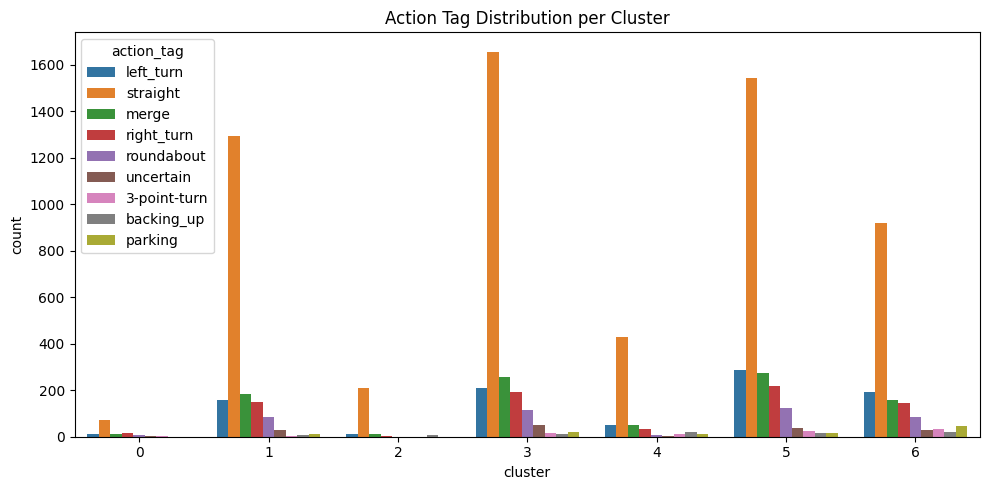

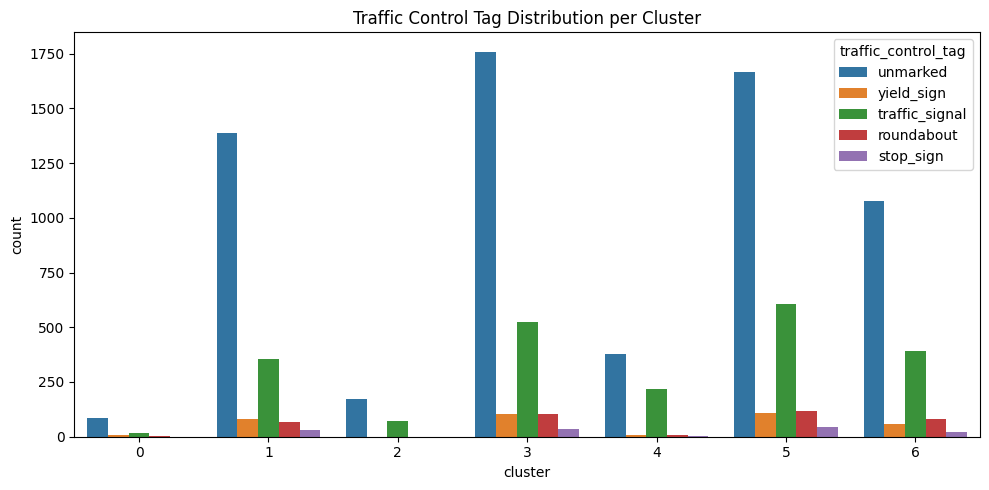

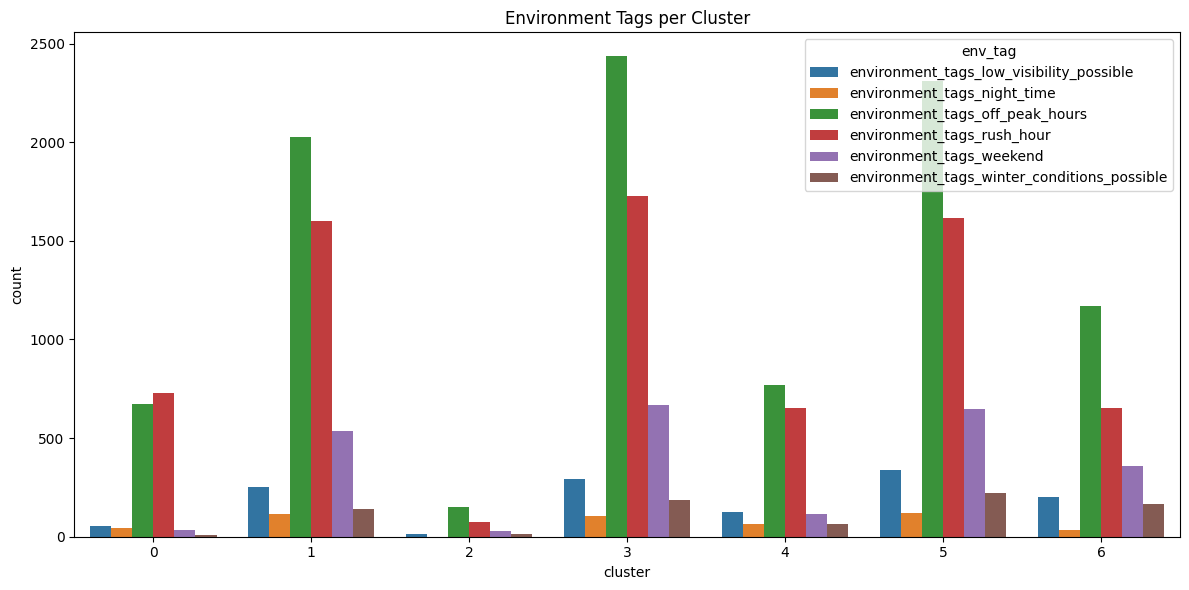

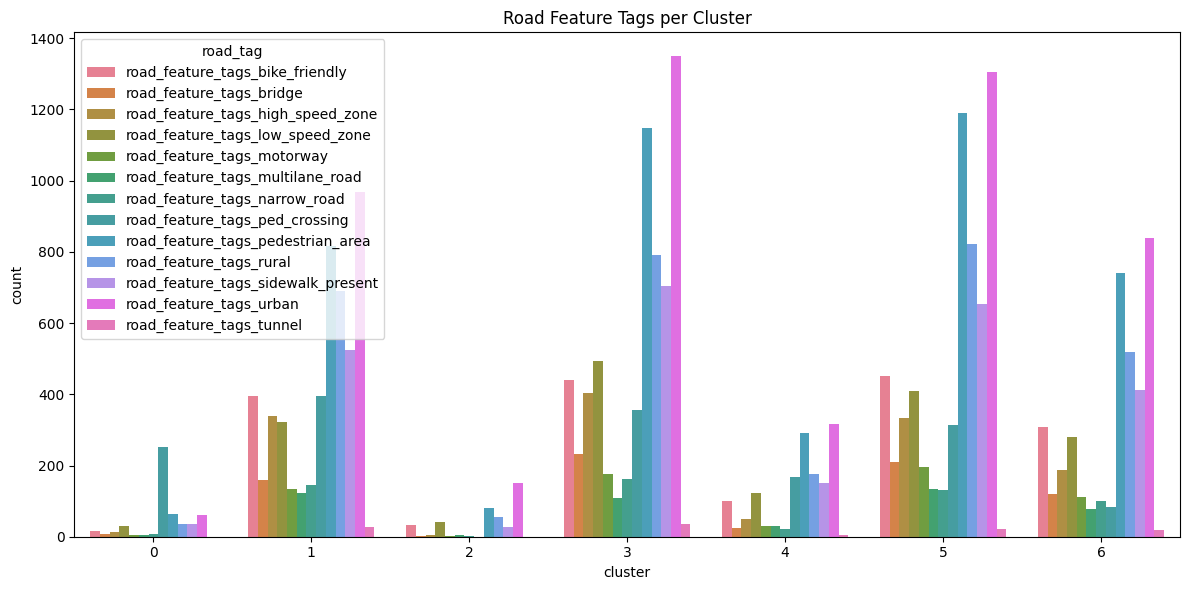

In [45]:
df_tags, df_ego = analyze_clusters(
    all_paths,
    cluster_labels,
    all_sources,
    graph_dir="../data/processed_graph--ical",     
    semantic_tag_dir="../data/semantic_tags"  
)

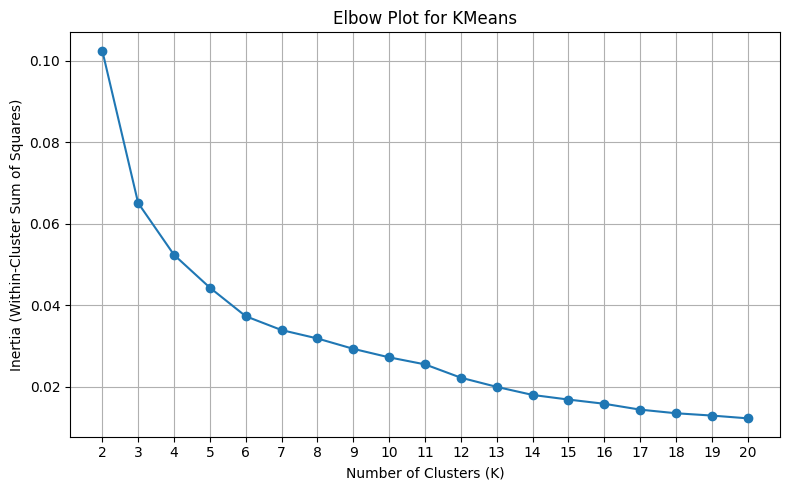

In [46]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Sweep K values ---
k_values = range(2, 21)
inertias = []

pca = PCA(n_components=10, random_state=42)
embeddings_10d = all_embeddings#pca.fit_transform(all_embeddings)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(embeddings_10d)
    inertias.append(kmeans.inertia_)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Plot for KMeans")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

/Users/mariantemprana/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



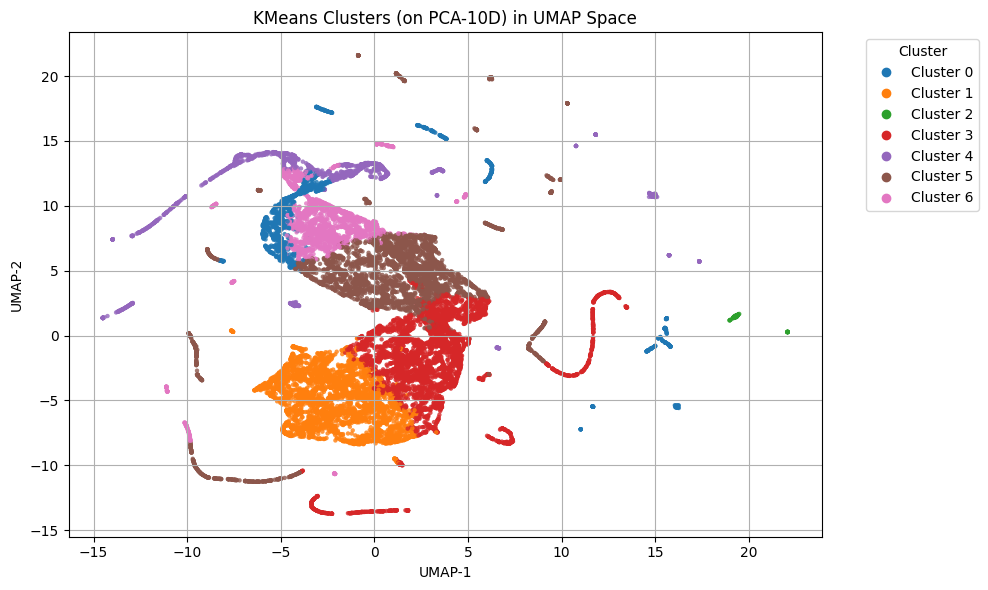

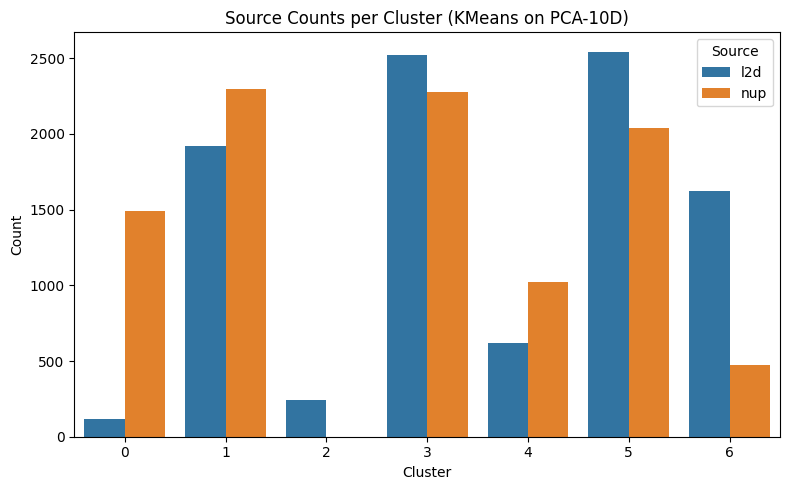

In [47]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_clusters = 7
# --- Reduce to 10D using PCA ---
#pca = PCA(n_components=15, random_state=42)
embeddings_10d = all_embeddings #pca.fit_transform(all_embeddings)

# --- KMeans Clustering  ---
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(embeddings_10d)

# --- UMAP Projection (2D) for Visualization ---
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_proj = umap_model.fit_transform(embeddings_10d)

# --- UMAP Plot ---
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_clusters)
colors = [palette[label] for label in cluster_labels]

plt.scatter(umap_proj[:, 0], umap_proj[:, 1], c=colors, s=10, alpha=0.8, linewidth=0)
plt.title("KMeans Clusters (on PCA-10D) in UMAP Space")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)

handles = [plt.Line2D([], [], marker='o', color=c, linestyle='', label=f'Cluster {i}')
           for i, c in enumerate(palette)]
plt.legend(handles=handles, title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# --- Source Counts per Cluster ---
df = pd.DataFrame({
    "cluster": cluster_labels,
    "source": all_sources,
})

counts = df.groupby(["cluster", "source"]).size().reset_index(name="count")
counts["cluster"] = counts["cluster"].astype(str)

plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="cluster", y="count", hue="source", dodge=True)

plt.title("Source Counts per Cluster (KMeans on PCA-10D)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Source")
plt.tight_layout()
plt.show()

100%|██████████| 19186/19186 [00:02<00:00, 7618.40it/s]


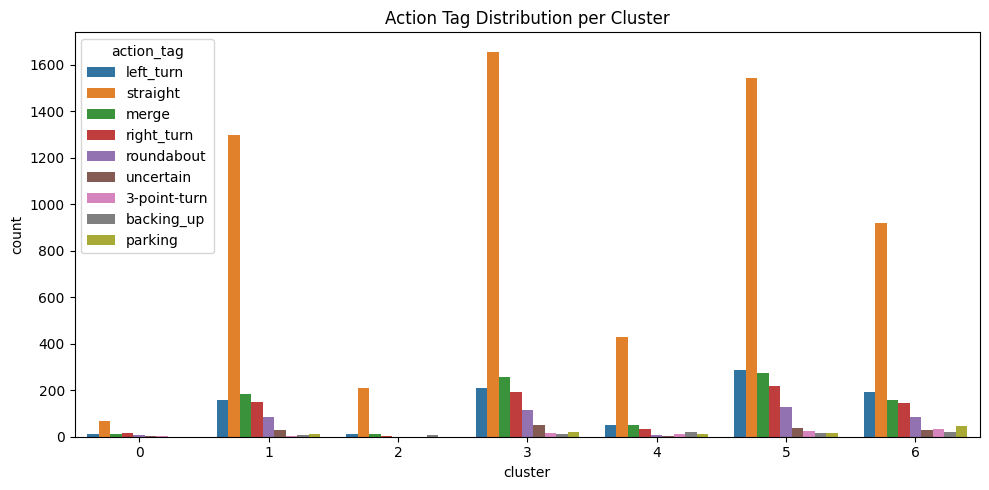

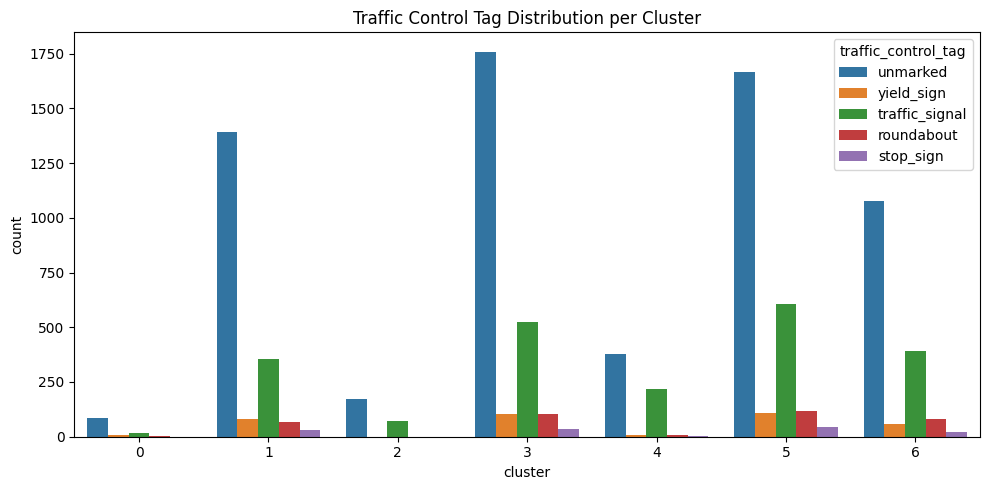

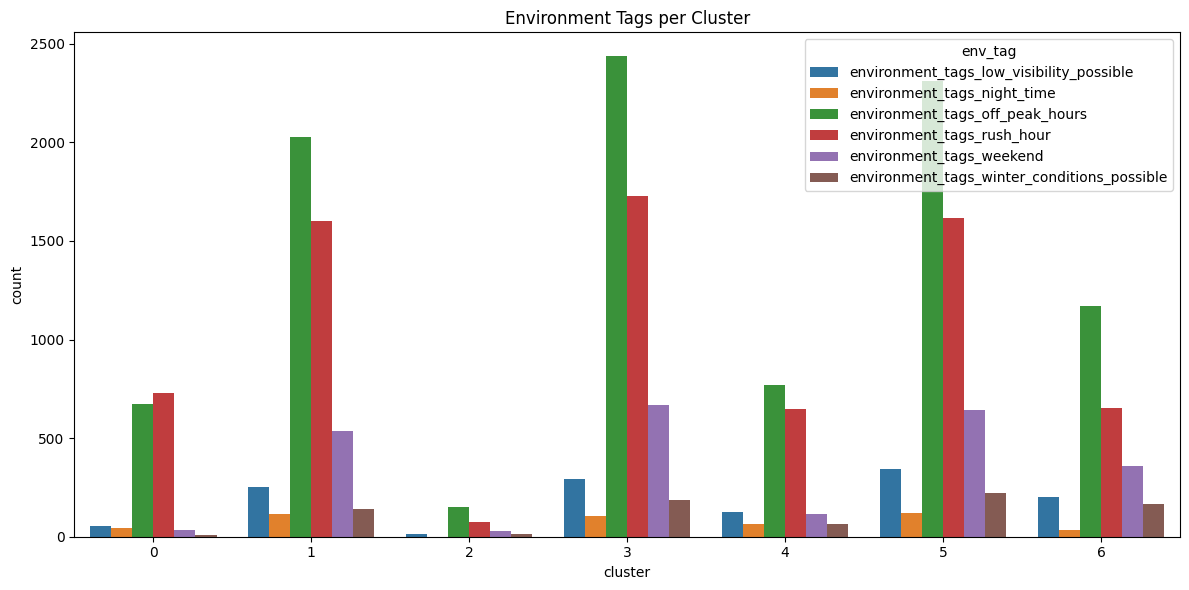

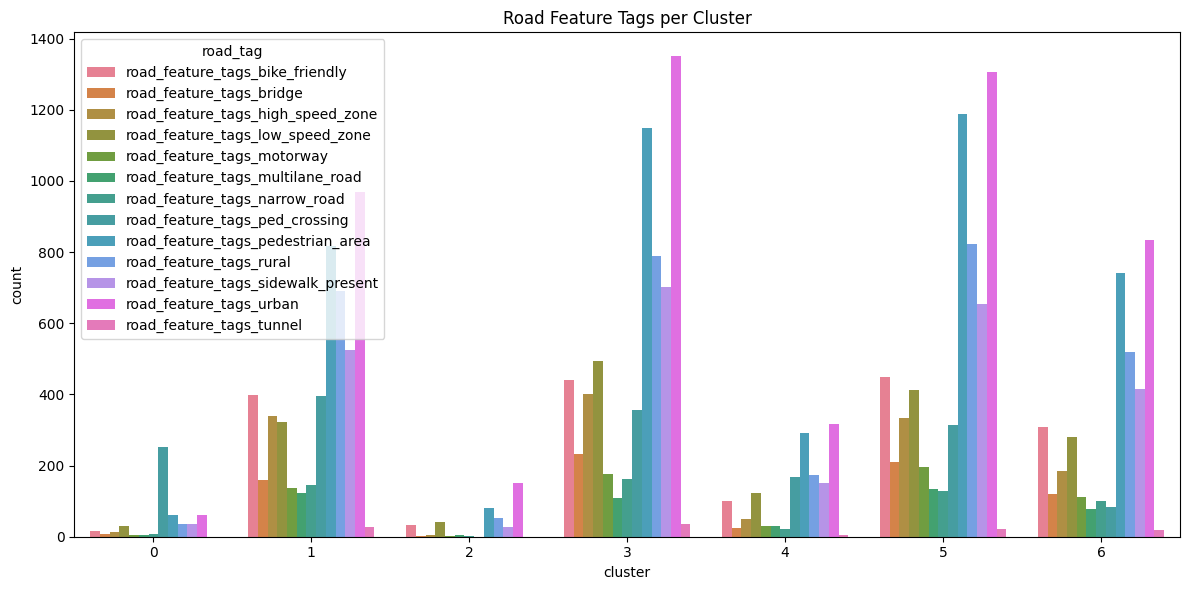

In [49]:
df_tags, df_ego = analyze_clusters(
    all_paths,
    cluster_labels,
    all_sources,
    graph_dir="../data/processed_gra--phical",     
    semantic_tag_dir="../data/semantic_tags"  
)

In [43]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_clusters(all_paths, cluster_labels, all_sources,
                     graph_dir="../data/processed_graphs",
                     semantic_tag_dir="../data/semantic_tags"):
    """
    Analyze clusters by combining semantic tags and ego features.
    Produces summary plots per cluster.
    Ego features are aggregated per cluster (mean ± std) to reduce load.
    """

    tag_rows = []
    ego_rows = []

    for path, cluster, source in tqdm(zip(all_paths, cluster_labels, all_sources), total=len(all_paths)):
        graph_id = int(path.split('_')[0])

        # --- Semantic tags path ---
        if 'nup' in source:
            tag_path = os.path.join(semantic_tag_dir, "NuPlan", f"{graph_id}_graph.json")
            graph_file = os.path.join(graph_dir, "nuplan", path)
        elif 'l2d' in source:
            tag_path = os.path.join(semantic_tag_dir, "l2d", f"episode_{graph_id:06d}.json")
            graph_file = os.path.join(graph_dir, "l2d", path)
        else:
            continue

        # --- Load semantic tags ---
        if os.path.exists(tag_path):
            with open(tag_path, 'r') as f:
                tag_data = json.load(f)

            row = {
                "cluster": cluster,
                "source": source,
                "action_tag": tag_data.get("action_tag", None),
                "traffic_control_tag": tag_data.get("traffic_control_tag", None),
                "road_feature_tags": tag_data.get("road_feature_tags", []),
                "environment_tags": tag_data.get("environment_tags", []),
            }
            tag_rows.append(row)

        # --- Load ego features ---
        if os.path.exists(graph_file):
            with open(graph_file, "r") as f:
                graph_data = json.load(f)

            ego_feats = graph_data.get("nodes", {}).get("ego", [{}])[0].get("features", {})
            ego_feats["cluster"] = cluster
            ego_feats["source"] = source
            ego_rows.append(ego_feats)

    # --- Step 2: Convert to DataFrames ---
    df_tags = pd.DataFrame(tag_rows)
    df_ego = pd.DataFrame(ego_rows)

    # --- Step 3: Expand multi-value tag columns ---
    def one_hot_expand(df, column):
        if column not in df.columns:
            return df
        exploded = df.explode(column)
        ohe = pd.get_dummies(exploded[column], prefix=column).groupby(exploded.index).sum()
        return df.drop(columns=[column]).join(ohe)

    if not df_tags.empty:
        df_tags = one_hot_expand(df_tags, "environment_tags")
        df_tags = one_hot_expand(df_tags, "road_feature_tags")

    # --- Step 4: Visualization (tags) ---
    if not df_tags.empty:
        # Action tags
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df_tags, x="cluster", hue="action_tag")
        plt.title("Action Tag Distribution per Cluster")
        plt.tight_layout()
        plt.show()

        # Traffic control
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df_tags, x="cluster", hue="traffic_control_tag")
        plt.title("Traffic Control Tag Distribution per Cluster")
        plt.tight_layout()
        plt.show()

        # Environment tags
        env_cols = [c for c in df_tags.columns if c.startswith("environment_tags_")]
        if env_cols:
            env_long = df_tags.melt(id_vars=["cluster"], value_vars=env_cols,
                                    var_name="env_tag", value_name="present")
            env_long = env_long[env_long["present"] > 0]
            plt.figure(figsize=(12, 6))
            sns.countplot(data=env_long, x="cluster", hue="env_tag")
            plt.title("Environment Tags per Cluster")
            plt.tight_layout()
            plt.show()

        # Road feature tags
        road_cols = [c for c in df_tags.columns if c.startswith("road_feature_tags_")]
        if road_cols:
            road_long = df_tags.melt(id_vars=["cluster"], value_vars=road_cols,
                                     var_name="road_tag", value_name="present")
            road_long = road_long[road_long["present"] > 0]
            plt.figure(figsize=(12, 6))
            sns.countplot(data=road_long, x="cluster", hue="road_tag")
            plt.title("Road Feature Tags per Cluster")
            plt.tight_layout()
            plt.show()

    # --- Step 5: Ego features (aggregated) ---
    if not df_ego.empty:
        # Keep numeric columns only
        numeric_cols = df_ego.select_dtypes(include="number").columns.tolist()
        if "cluster" in numeric_cols:
            numeric_cols.remove("cluster")

        if numeric_cols:
            # Aggregate mean and std per cluster
            ego_summary = df_ego.groupby("cluster")[numeric_cols].agg(["mean", "std"]).reset_index()

            # Flatten MultiIndex column names (feature_stat)
            ego_summary.columns = [
                "_".join(col).rstrip("_") if isinstance(col, tuple) else col
                for col in ego_summary.columns
            ]

            # Melt to long format
            ego_long = ego_summary.melt(id_vars="cluster", var_name="feature_stat", value_name="value")

            # Split feature_stat into "feature" and "stat"
            ego_long[["feature", "stat"]] = ego_long["feature_stat"].str.rsplit("_", n=1, expand=True)

            # Plot means with std as error bars
            plt.figure(figsize=(14, 7))
            sns.barplot(
                data=ego_long[ego_long["stat"] == "mean"],
                x="cluster", y="value", hue="feature",
                errorbar="sd"
            )
            plt.title("Ego Vehicle Features per Cluster (mean ± std)")
            plt.tight_layout()
            plt.show()


    return df_tags, df_ego


In [33]:
df_ego

""
